In [153]:
import matplotlib.pyplot as plt
import seaborn
import numpy as np
import os
import matplotlib as mpl
seaborn.set_context('talk')

In [2]:
with open('active_learning_data/dataset_names.txt') as f:
    names = f.readlines()
    names = [n[:-1] for n in names]
print(names)
print(len(names))

['antibacterial', 'anticancer', 'antifungal', 'antiHIV', 'antiMRSA', 'antiparasital', 'antiviral', 'hemolytic', 'soluble', 'shp2', 'tula2']
11


(0.7313288461538461, 0.13603487100155578)

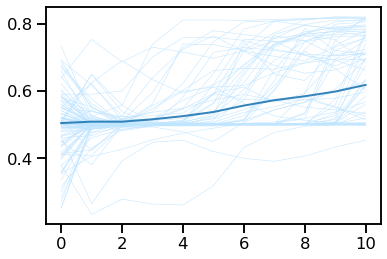

In [285]:
def plot_condition(ax, label, color, linestyle, location, trace=True, horizontal=False):
    # load lines
    avg = None
    aucs = []
    # mimic how an alpha would blend,
    # but don't use alpha so that we don't create
    # false "mean lines"
    base_color = mpl.colors.to_rgb(color)
    base_hsv = mpl.colors.rgb_to_hsv(base_color)
    base_hsv[1] *= 0.3
    base_hsv[2] = 1.0
    trace_color = mpl.colors.hsv_to_rgb(base_hsv)
    for i in range(100):
        fn = '{}/{}_withheld_accuracy.txt'.format(location, str(i).zfill(4))
        auc = '{}/{}_auc.txt'.format(location, str(i).zfill(4))
        if not os.path.exists(fn):
            break
        d = np.genfromtxt(fn)
        auc = np.genfromtxt(auc)
        aucs.append(auc)
        if avg is None:
            avg = d
        else:
            avg += d
        if trace:
            ax.plot(d, alpha=1.0, lw=0.5, color=trace_color, linestyle=linestyle)        
    # should always go one past to get a break
    if i == 0:
        raise RuntimeError('Failed in ' + fn)
    avg /= i
    if horizontal:
        ax.axhline(avg[-1], lw=1.0 if trace else 1.5, label=label, color=color, linestyle=linestyle)
    else:
        ax.plot(avg, alpha=0.9, lw=2.0 if trace else 1.5, label=label, color=color, linestyle=linestyle)
    return (np.mean(aucs), np.std(aucs))
plt.figure()
ax = plt.gca()
#plot_condition(ax, 'foo', 'C0', '-', 'reptile-weights/random/0/', trace=False)
plot_condition(ax, 'foo', 'C0', '-', 'models/random/0/', trace=True)

KeyError: 'random'

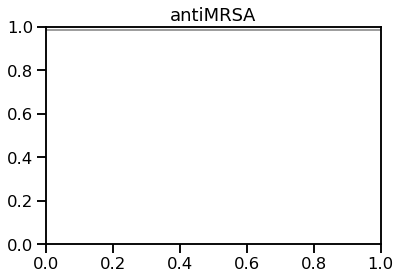

In [271]:
def plot_dataset(ax, ml_location, location, strategy, index, legend=False, ml=True):
    ax.set_title(names[index])
    index = str(index)
    strategy_names = {'umin': 'Uncertainty Minimization', 'qbc': 'Query by Committee'}
    aucs = []
    aucs.append(plot_condition(ax, 'standard', 'gray', '-', os.path.join(location, 'all', index), trace=False, horizontal=True))
    aucs.append(plot_condition(ax, strategy_names[strategy], 'C0', '-', os.path.join(location, strategy, index), trace=not ml))
    if ml:
        aucs.append(plot_condition(ax, 'ML+' + strategy_names[strategy], 'C1', '-', os.path.join(ml_location, strategy, index), trace=True))
    
    aucs.append(plot_condition(ax, 'Random Choice', 'C2', '--', os.path.join(location, 'random', index), trace=False))
    if ml:
        aucs.append(plot_condition(ax, 'ML+Random Choice', 'C3', '--', os.path.join(ml_location, 'random', index), trace=False))
    

    
    if legend:
        ax.legend()
        ax.set_xlabel('Given Examples')
        ax.set_ylabel('Accuracy')
    return aucs
plt.figure()
ax = plt.gca()
plot_dataset(ax, 'reptile-models', 'models', 'random', 4, legend=True, ml=False)

In [252]:
def plot_strategy(ml_location, location, strategy, ml=True, stop=len(names)):
    fig, axs= plt.subplots(nrows=3, ncols=4, figsize=(12,8), sharex=True, sharey=True)
    print('Data Standard {} '.format(strategy), end='')
    if ml:
        print('ML+{} Random ML+Random'.format(strategy))
    else:
        print('Random')
    for i in range(3):
        for j in range(4):
            k = i * 4 + j
            if k == stop:
                axs[i,j].set_axis_off()
                axs[i,j].plot([], label='Random Choice', color='C2', linestyle='--')
                axs[i,j].plot([], label='Active Learner', color='C0', linestyle='-')
                axs[i,j].plot([], label='Standard', color='gray', linestyle='-')
                if ml:
                    axs[i,j].plot([], label='ML+Random Choice', color='C3', linestyle='--')
                    axs[i,j].plot([], label='ML+Active Learner', color='C1', linestyle='-')
                axs[i,j].legend(loc='center', fontsize=12)
                break
            line = [names[k]] + plot_dataset(axs[i,j], ml_location, location, strategy, k, k == len(names), ml=ml)
            if ml:
                print('{} {:.2f}+/-{:.2f} {:.2f}+/-{:.2f} {:.2f}+/-{:.2f}'.format(line[0], *line[1], *line[3], *line[5]))
        if k == stop:
            break
    plt.savefig('{}{}.png'.format(strategy, '-ml' if ml else ''), dpi=300)

Data Standard umin ML+umin Random ML+Random
antibacterial 0.76+/-0.00 0.66+/-0.00 0.51+/-0.01
anticancer 0.91+/-0.00 0.93+/-0.01 0.86+/-0.01
antifungal 0.85+/-0.00 0.67+/-0.00 0.50+/-0.00
antiHIV 0.73+/-0.00 0.76+/-0.00 0.43+/-0.00
antiMRSA 0.57+/-0.00 0.70+/-0.01 0.64+/-0.01
antiparasital 0.70+/-0.00 0.46+/-0.00 0.55+/-0.02
antiviral 0.56+/-0.00 0.36+/-0.00 0.71+/-0.01
hemolytic 0.74+/-0.00 0.79+/-0.00 0.65+/-0.00
soluble 0.74+/-0.00 0.49+/-0.02 0.56+/-0.05
shp2 0.78+/-0.00 0.64+/-0.02 0.65+/-0.02
tula2 0.50+/-0.00 0.43+/-0.02 0.62+/-0.01


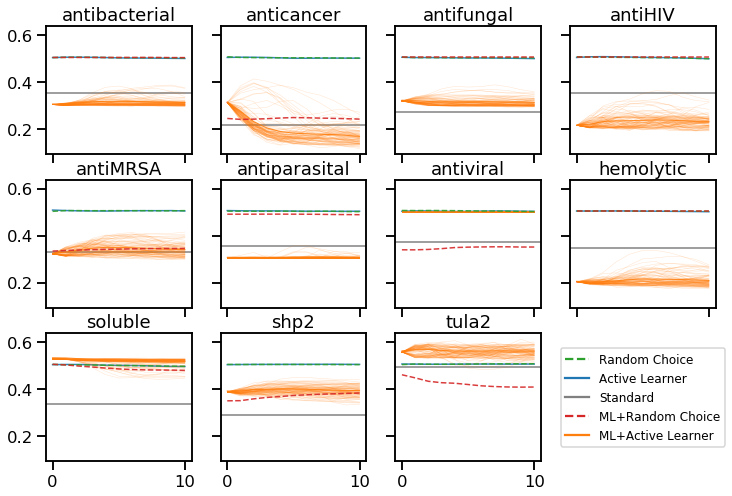

In [143]:
plot_strategy('reptile-weights', 'models', 'umin')

Data Standard umin ML+umin Random ML+Random
antibacterial 0.84+/-0.00 0.86+/-0.01 0.85+/-0.01
anticancer 0.84+/-0.00 0.85+/-0.01 0.86+/-0.01
antifungal 0.85+/-0.00 0.84+/-0.00 0.83+/-0.01
antiHIV 0.92+/-0.00 0.92+/-0.01 0.90+/-0.01
antiMRSA 0.90+/-0.00 0.91+/-0.02 0.75+/-0.24
antiparasital 0.98+/-0.00 0.95+/-0.01 0.97+/-0.01
antiviral 0.86+/-0.00 0.44+/-0.03 0.87+/-0.01
hemolytic 1.00+/-0.00 0.98+/-0.00 0.99+/-0.00
soluble 0.62+/-0.00 0.56+/-0.01 0.55+/-0.00
shp2 0.63+/-0.00 0.54+/-0.03 0.61+/-0.08
tula2 0.68+/-0.00 0.43+/-0.05 0.52+/-0.12


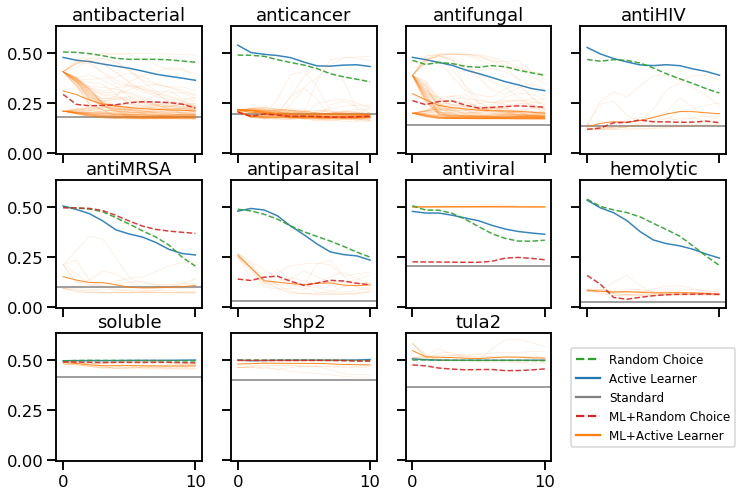

In [76]:
plot_strategy('reptile-models', 'models', 'umin', ml=True)

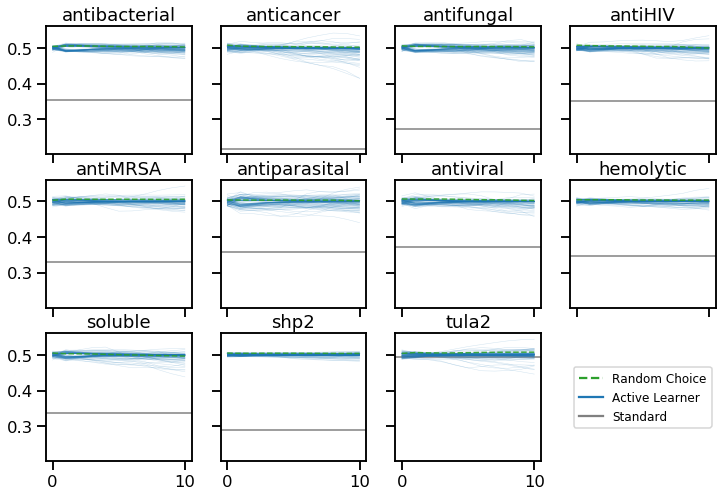

In [98]:
plot_strategy('reptile-weights', 'models', 'qbc', ml=False)

0 6
1 6
2 6
3 6
4 6
5 6
6 6


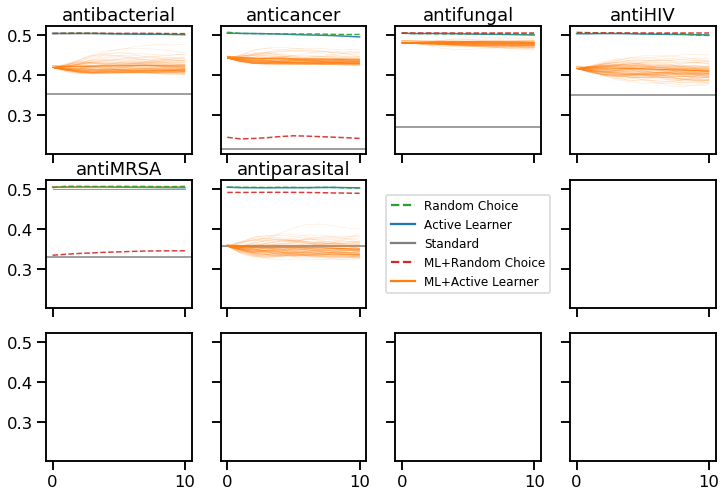

In [111]:
plot_strategy('reptile-weights', 'models', 'qbc', ml=True, stop=6)